### ARIMA 

- Intuition
- Non-stationary data 
- Level of integration 
- Stationary data 


It has $order=(p,d,q)$, where p - AR, and q - MA

$d$ - Integration order. It represents the number of times we need to integrate the time series to ensure stationary.

**Integrated Model**: Accounting for the non-seasonal difference between periods to establish a stationary. 

**Equation**

ARIMA(1,1,1) 

$ \Delta P_t = C + \phi_1 \Delta P_{t-1} + \theta_1 \epsilon_{t-1} + \epsilon_t$

- $\Delta P_t$: $ P_t -  P_{t-1}$
- $P_t, P_{t-1}$: Values in the current period and a period ago respectively 
- $ \epsilon_t, \epsilon_{t-1}$: Error terms 
- $C$: Constant
- $\phi_1$: what part of the value last period is relevant in explaining the current one
- $\theta_1$: what part of the value last period is relevant in explaining the current one

**In a very simpler term, it is a model for a newly generated time series which is stationary.**

In addition, ARIMA does not have ACF, and PACF to suggest the optimal order for different components. We will examine the ACF of $\epsilon_t$ to have better idea on better lags to use.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set()


#### Primary preprocessing 

In [5]:
raw_csv_data = pd.read_csv("./../datasets/Index2018.csv")
df = raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst=True)
df.set_index("date", inplace=True)
df = df.asfreq('b')
df = df.fillna(method='ffill')

In [6]:
df.head()


,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [7]:
# picking market value for FTSE
df['market_value'] = df.ftse

df.drop(["spx", "ftse", "nikkei", "dax"], axis=1, inplace=True)
df.describe()

,market_value
count,6277.000000
mean,5423.679824
std,1145.616719
min,2876.600000
25%,4486.730000
50%,5663.300000
75%,6304.630175
max,7778.637689


Split the data

In [8]:
train_locs = int(df.shape[0]*0.8)
train_locs


5021

In [9]:
df, df_test = df.iloc[:train_locs], df.iloc[train_locs:]
df, df_test

(            market_value
 date                    
 1994-01-07       3445.98
 1994-01-10       3440.58
 1994-01-11       3413.77
 1994-01-12       3372.02
 1994-01-13       3360.01
 ...                  ...
 2013-04-01       6411.74
 2013-04-02       6490.66
 2013-04-03       6420.28
 2013-04-04       6344.11
 2013-04-05       6249.77
 
 [5021 rows x 1 columns],
             market_value
 date                    
 2013-04-08   6276.940000
 2013-04-09   6313.200000
 2013-04-10   6387.370000
 2013-04-11   6416.140000
 2013-04-12   6384.390000
 ...                  ...
 2018-01-23   7731.827774
 2018-01-24   7643.428966
 2018-01-25   7615.839954
 2018-01-26   7665.541292
 2018-01-29   7671.533300
 
 [1256 rows x 1 columns])

LLR Test 

In [10]:
def llr_test(model_one, model_two, df=1):
    l1 = model_one.fit().llf
    l2 = model_two.fit().llf
    lr = (2*(l2-l1))
    p = chi2.sf(lr, df).round(3)
    return p


Creating a return values 

In [11]:
df['returns']= df.market_value.pct_change(1)*100
df[:5]

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


ARIMA (1,1,1)

In [12]:
model_1_1_1_arima = ARIMA(df.market_value, order=(1,1,1))
result_1_1_1_1_arima = model_1_1_1_arima.fit()
result_1_1_1_1_arima.summary()

c:\Users\skb976\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\skb976\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27604.005
Date:                Fri, 19 Aug 2022   AIC                          55214.010
Time:                        15:45:59   BIC                          55233.574
Sample:                    01-07-1994   HQIC                         55220.865
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7460      0.059     12.659      0.000       0.631       0.862
ma.L1         -0.7920      0.053    -14.930      0.000      -0.896      -0.688
sigma2      3498.4453     40.925     85.484      0.000    3418.233    3578.657
===================================================================================
Ljung-Box (L1) (Q):                   2.62   Jarque-Bera (JB):              3326.29
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Residuals and their ACF

In [15]:
df['residuals_1_1_1'] = result_1_1_1_1_arima.resid

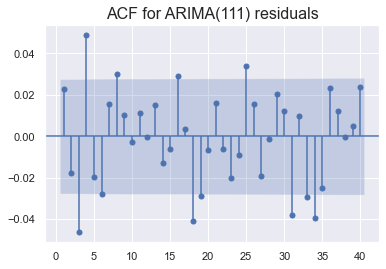

In [16]:
sgt.plot_acf(df['residuals_1_1_1'][1:], zero=False, lags=40)
plt.title("ACF for ARIMA(111) residuals", size=16)
plt.show()

We can observe that the third and fourth lags are highly significant. Incorporating these lags into our model might significantly improve performance.

#### Higher Level ARIMAs